## Problem 1

In [1]:
import pandas as pd
import numpy as np
from functools import lru_cache
from sklearn.metrics import mean_squared_error

# 1. Load train and test data (MovieLens u1)
cols = ['user_id', 'item_id', 'rating', 'timestamp']
train = pd.read_csv('Datasets/ml-100k/u1.base', sep='\t', names=cols)
test  = pd.read_csv('Datasets/ml-100k/u1.test', sep='\t', names=cols)

# 2. Build user -> {item: rating} and item -> {user: rating}
user_ratings = train.groupby('user_id').apply(lambda df: dict(zip(df.item_id, df.rating)),include_groups=False).to_dict()
item_ratings = train.groupby('item_id').apply(lambda df: dict(zip(df.user_id, df.rating)),include_groups=False).to_dict()

In [6]:
# 3. Pearson similarity with caching
@lru_cache(maxsize=None) #stores results of function calls to avoid recalculating for the same inputs
def pearson(u, v):
    '''
    computes how similar two users are based on their ratings for items they both rated. 
    The Pearson correlation ranges from -1 (opposite preferences) to 1 (identical preferences).
    :param u: user u's ID
    :param v: user v's ID
    :return: correlation of 2 users
    '''
    ru = user_ratings.get(u, {})
    rv = user_ratings.get(v, {})
    common = set(ru.keys()).intersection(rv.keys())
    if len(common) < 2:
        return 0
    u_r = np.array([ru[i] for i in common], dtype=float) # User u's ratings for common items
    v_r = np.array([rv[i] for i in common], dtype=float) # User v's ratings for common items
    u_mean = u_r.mean()
    v_mean = v_r.mean()
    num = ((u_r - u_mean) * (v_r - v_mean)).sum() # Sum of products of centered ratings
    den = np.sqrt(((u_r - u_mean) ** 2).sum()) * np.sqrt(((v_r - v_mean) ** 2).sum()) # Product of the square roots of the sum of squared centered ratings
    return num / den if den != 0 else 0

# 4. Predict ratings on test set
preds = []
true = []
# Predict ratings for user-item pairs in a test dataset using a user-based collaborative filtering approach.
for _, row in test.iterrows():
    u, i, true_r = row.user_id, row.item_id, row.rating
    # Get all users who rated item i
    neighbors = item_ratings.get(i, {})

    num = 0
    den = 0
    # compute means
    mean_u = np.mean(list(user_ratings.get(u, {}).values())) if user_ratings.get(u) else 0
    for v, r_vi in neighbors.items():
        if v == u: 
            continue
        sim = pearson(u, v)
        # skip similarity <= 0
        if sim <= 0:
            continue
        mean_v = np.mean(list(user_ratings[v].values()))
        num += sim * (r_vi - mean_v)
        den += abs(sim)
    pred = mean_u + (num / den) if den > 0 else mean_u
    # clip to rating bounds
    pred = min(5, max(1, pred))
    preds.append(pred)
    true.append(true_r)

In [10]:
# 5. Compute RMSE
mse = mean_squared_error(true, preds)
rmse = np.sqrt(mse)
print(f"RMSE on u1.test: {rmse:.4f}")

RMSE on u1.test: 0.9624


## Problem 3A  

In [13]:
from collections import defaultdict
import igraph as ig
from collections import deque

def load_graph(edge_list_path, directed=False):
    edge_df = pd.read_csv(edge_list_path, header=None)[[0, 1]]
    edges = [tuple(x) for x in edge_df.values]
    G = ig.Graph(edges=edges, directed=directed)
    print(f"Loaded graph: {G.vcount()} vertices, {G.ecount()} edges")
    return G

def compute_betweeness(graph):
    """
    Computes edge betweenness centrality, which measures the importance of each edge 
    by counting how often it lies on the shortest paths between all pairs of vertices.
    Returns a list of betweenness values for each edge.
    """
    n = graph.vcount() #number of nodes
    m = graph.ecount() #number of edges
    EB = np.zeros(m) # to store edge betweenness values
    for s in range(n):
        S = [] # stack of vertices in order of visitation
        P = [[] for _ in range(n)]  # P[w] = list of predecessors of w on shortest paths from s
        sigma = np.zeros(n) # sigma[w] = number of shortest paths from s to w
        dist = [-1] * n # dist[w] = distance from s to w
        sigma[s] = 1 
        dist[s] = 0 # Distance from s to each vertex
        # BFS to find shortest paths from s
        Q = deque([s])
        while Q:
            v = Q.popleft()
            S.append(v)
            for w in graph.neighbors(v):
                # first time seeing w?
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    Q.append(w)
                # is v->w part of a shortest path?
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v)
        # delta[v] = dependency of source s on vertex v                
        delta = np.zeros(n)
        # Backtrack through vertices in reverse order of visitation
        while S:
            w = S.pop() # Current vertex
            for v in P[w]: # For each predecessor v of w
                c = (sigma[v] / sigma[w]) * (1 + delta[w]) # Contribution to edge (v,w) betweenness
                eid = graph.get_eid(w, v)
                EB[eid] += c
                delta[v] += c
    EB = [eb_val / 2 for eb_val in EB] # Normalize edge betweenness (divide by 2 for undirected graphs)
    return EB
    
def find_components(graph):
    '''
    Finds all connected components in an undirected graph, where a component is a set of vertices where each pair is connected by a path.
    Returns list of connected components from a graph.
    '''
    visited = [False] * graph.vcount()
    components = []

    def dfs(start, comp):
        visited[start] = True
        comp.append(start)
        for neighbor in graph.neighbors(start):
            if not visited[neighbor]:
                dfs(neighbor, comp)
    # Iterate over all vertices
    for v in range(graph.vcount()):
        if not visited[v]:
            comp = []
            # Run DFS to find all vertices in this component
            dfs(v, comp)
            components.append(comp)

    return components

In [24]:
def girvan_newman_k_commponents(graph, k):
    """
    Perform Girvan-Newman algorithm to partition graph into k communities.
    Iteratively removes edges with highest betweenness until k components are formed.
    
    Args:
        graph: igraph.Graph object (undirected)
        k: Desired number of communities (1 <= k <= number of vertices)
    
    Returns:
        igraph.Graph: Modified graph with edges removed to form k components
    """
    g_work = graph.copy()
    if k < 1 or k > graph.vcount():
        raise ValueError("k must be between 1 and the number of vertices")
    # iteratively remove one highest‐betweenness edge
    while len(find_components(g_work)) < k:
        eb = compute_betweeness(g_work)     
        max_eid = int(np.argmax(eb))
        g_work.delete_edges([max_eid])
    return g_work


def compute_modularity(graph, communities):
    """
    Compute modularity of a partition.
    communities: igraph VertexClustering OR list of vertex‑ID lists.
    """
    if isinstance(communities, ig.clustering.VertexClustering):
        membership = communities.membership
    else:
        membership = [0] * graph.vcount()
        for cid, comp in enumerate(communities):
            for vid in comp:
                membership[vid] = cid
    return graph.modularity(membership)

In [21]:
edge_list_file = "Datasets/Flickr/data/Flickr_sampled_edges/edges_sampled_map_2K.csv"
G = load_graph(edge_list_file, directed=False)

Loaded graph: 318 vertices, 2098 edges


In [25]:
new_g = girvan_newman_k_commponents(G, 6)
communities = find_components(new_g)
print("Partition sizes:", [len(c) for c in communities])
print(f"Modularity = {compute_modularity(new_g,communities):.4f}")

Partition sizes: [177, 34, 101, 2, 2, 2]
Modularity = 0.4117


C:\Users\fred9\AppData\Local\Temp\ipykernel_15464\3911868106.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_comms))


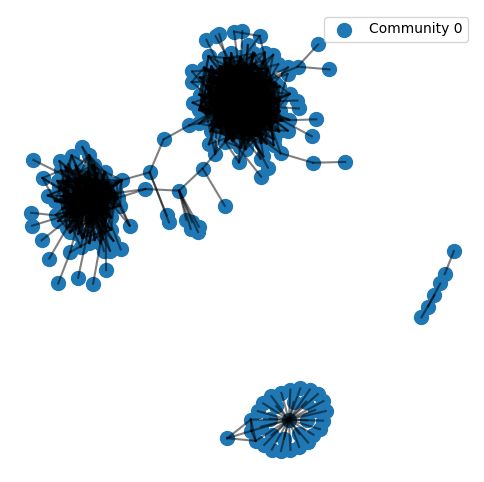

In [29]:
plot_graph(G)

C:\Users\fred9\AppData\Local\Temp\ipykernel_15464\3911868106.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_comms))


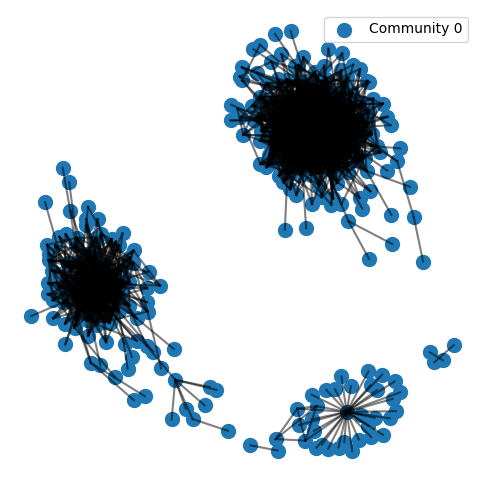

In [28]:
plot_graph(new_g)

In [11]:
# best_part, best_score = girvan_newman(G)
# print("Best partition sizes:", [len(c) for c in best_part])
# print(f"Best modularity = {best_score:.4f}")

In [56]:
def girvan_newman_early_stop(graph):
    """
    Perform Girvan–Newman by edge‑removal, but choose the final cut
    by picking the partition with maximum modularity.
    
    Returns:
      best_comms: list of lists of vertex‐IDs (the best partition)
      best_Q:     float modularity score of that partition
    """
    g_work = graph.copy()
    best_Q = -1.0
    prev_Q = -1.0
    best_comms = [graph.vs.indices]  # trivial 1‐community partition
    
    # iteratively remove one highest‐betweenness edge
    while g_work.ecount() > 0:
        eb = compute_betweeness(g_work)      # your Brandes‐based eb calculator
        max_eid = int(np.argmax(eb))
        g_work.delete_edges([max_eid])
        
        # get current connected components
        comps = g_work.components()
        if len(comps) > 1:
            # compute modularity of this split on the **original** graph
            Q = compute_modularity(graph, comps)
            
            if Q < prev_Q:
                break
            if Q > best_Q:
                best_Q = Q
                best_comms = list(comps)      # snapshot the current split
            prev_Q = Q
    return best_comms, best_Q

In [57]:
best_part2, best_score2 = girvan_newman_early_stop(G)
print("Best partition sizes:", [len(c) for c in best_part2])
print(f"Best modularity = {best_score2:.4f}")

Best partition sizes: [172, 34, 89, 4, 3, 2, 2, 8, 2, 2]
Best modularity = 0.4147


## Problem 3B

In [14]:
g = load_graph("Datasets/sparse_adj_hw6_3.txt")

Loaded graph: 751 vertices, 113094 edges


In [15]:
def leading_eigenvector_bisection(g, tol=1e-6, max_iter=1000):
    """
    Spectral bisection using Newman's modularity matrix.
    Returns a vector s of +1 / -1 indicating the two communities.
    """
    n = g.vcount()
    m = g.ecount()
    # degree array k
    k = np.array(g.degree(), dtype=float)
    # total number of edges (for modularity): 2m = sum of degrees
    two_m = k.sum()

    # adjacency in sparse form via igraph neighbors
    neighbors = [g.neighbors(v) for v in range(n)]

    def B_mul(x):
        """
        Compute matrix-vector product y = B x without forming B explicitly:
        B = A - (k k^T) / (2m)
        so  Bx = A x - k * (k^T x) / (2m)
        where A is the adjacency matrix, k is the degree vector, and 2m is the sum of degrees.
        """
        # A x
        Ax = np.zeros(n, dtype=float)
        for i in range(n):
            for j in neighbors[i]:
                Ax[i] += x[j]
        # correction term
        k_dot_x = k.dot(x)
        return Ax - k * (k_dot_x / two_m) # Bx = Ax - correction

    # power iteration to get leading eigenvector of B
    v = np.random.rand(n)
    v -= v.mean()
    for _ in range(max_iter):
        v_new = B_mul(v)
        # enforce orthogonality to trivial eigenvector (1,1,...)
        v_new -= v_new.mean()
        norm = np.linalg.norm(v_new)
        if norm < tol:
            break
        v_new /= norm
        if np.linalg.norm(v_new - v) < tol:
            v = v_new
            break
        v = v_new

    # partition by sign of components in v
    s = np.ones(n, dtype=int)
    s[v < 0] = -1 # # Set to -1 where eigenvector component is negative
    return s

In [99]:
s = leading_eigenvector_bisection(g)
group1 = [i for i, val in enumerate(s) if val == 1]
group2 = [i for i, val in enumerate(s) if val == -1]
subgraphs = [g.subgraph(group1, implementation="create_from_scratch"), g.subgraph(group2, implementation="create_from_scratch")]

In [18]:
import matplotlib.pyplot as plt

In [16]:
def plot_graph(graph):
    layout = graph.layout("kk")  # Fruchterman-Reingold layout
    coords = list(zip(*layout.coords))
    plt.figure(figsize=(6,6))
    plt.scatter(*coords, s=100)
    for edge in graph.get_edgelist():
        x = [layout[edge[0]][0], layout[edge[1]][0]]
        y = [layout[edge[0]][1], layout[edge[1]][1]]
    plt.plot(x, y, 'k-', alpha=0.5)
    plt.axis("off")
    plt.show()

In [27]:
def plot_graph(graph, membership=None):
    layout = graph.layout("kk")  # Kamada-Kawai layout (not Fruchterman-Reingold)
    coords = np.array(layout.coords)
    
    plt.figure(figsize=(6,6))
    
    if membership is None:
        membership = [0] * graph.vcount()  # Default: all nodes same community

    membership = np.array(membership)
    unique_comms = np.unique(membership)
    
    # Assign one color per community
    colors = plt.cm.get_cmap('tab10', len(unique_comms))
    
    for comm_id in unique_comms:
        idx = np.where(membership == comm_id)[0]
        plt.scatter(coords[idx,0], coords[idx,1], s=100, label=f"Community {comm_id}", color=colors(comm_id))
    
    # Draw edges
    for edge in graph.get_edgelist():
        x = [coords[edge[0],0], coords[edge[1],0]]
        y = [coords[edge[0],1], coords[edge[1],1]]
        plt.plot(x, y, 'k-', alpha=0.5)
    
    plt.axis("off")
    plt.legend()
    plt.show()

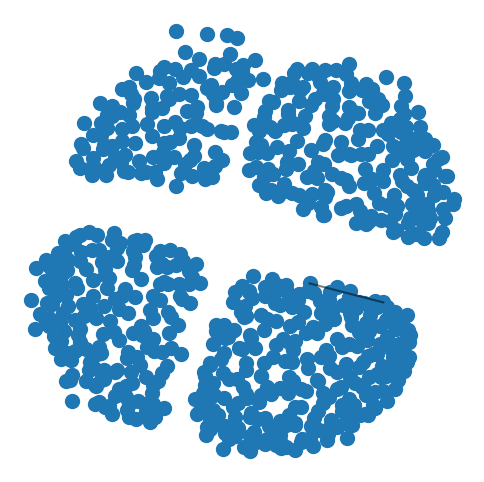

In [19]:
plot_graph(g)

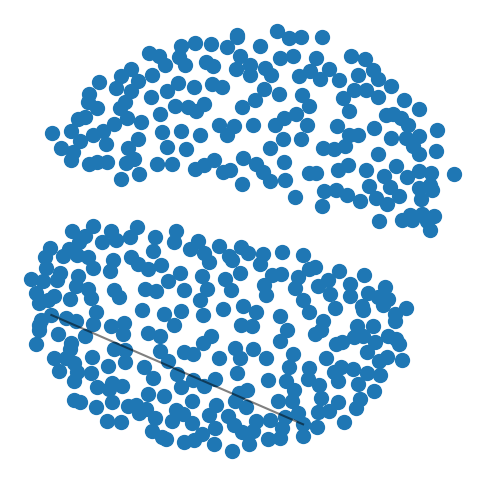

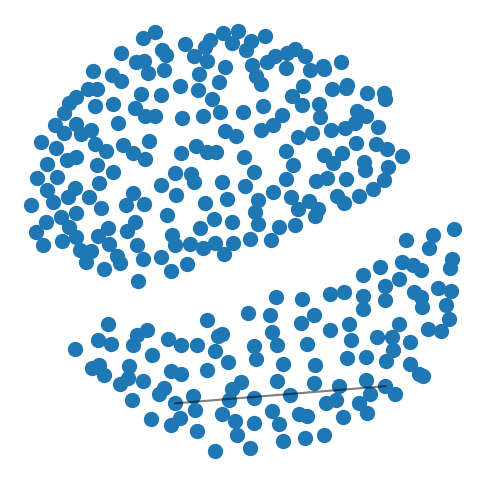

In [101]:
for sub_g in subgraphs:
    plot_graph(sub_g) 

## Probelm 4

In [111]:
import heapq
import json
from utils import get_rel_score_word2vecbase, load_node_label_lookup

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from nltk import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


In [3]:
import utils

In [1]:
import heapq
from utils import (
    get_rel_score_word2vecbase,
    load_graph, 
    load_node_label_lookup
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

NODE_LABEL_PATH = './Datasets/node_label_lookup.json'
QUESTIONS_PATH  = './Datasets/questions.txt'

def load_questions(path):
    questions = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            qid, text, start, template, _, gold = eval(line)
            gold_ids = [a['AnswerArgument'] for a in gold]
            questions[qid] = {
                'start':    start,
                'text':     text,
                'template': template,
                'gold':     set(gold_ids)
            }
    return questions

def answer_question(start, query, graph,
                    depth_limit, beam_width=10, threshold=0.0):
    """
    Use beam search to find candidate answer nodes up to depth_limit hops from the start node.
    Scores paths based on similarity between relations and query using get_rel_score_word2vecbase.
    Args:
        start (int): Starting node ID
        query (str): Query relation (e.g., "ns:occupation")
        graph (list): Adjacency list where graph[node] = [(relation, neighbor), ...]
        depth_limit (int): Maximum number of hops to search
        beam_width (int): Maximum number of paths to keep in the beam (default: 10)
        threshold (float): Minimum similarity score for relations (default: 0.0)
    Returns a dict: Mapping of node_id to best score (for nodes reached at depth_limit)
    """
    beam = [(-1.0, 0, start)]
    results = {}
    # unify needed form
    target_rel = query if query.startswith("ns:") else "ns:"+query

    while beam:
        neg_score, depth, node = heapq.heappop(beam)
        score = -neg_score

        for raw_rel, nbr in graph[node]:
            # normalize relation
            rel = raw_rel if raw_rel.startswith("ns:") else "ns:"+raw_rel
            sim = get_rel_score_word2vecbase(rel, query)

            if sim < threshold:
                continue

            new_score = score * sim

            if depth + 1 == depth_limit:
                # **collect** every final‐hop candidate by score
                results[nbr] = max(results.get(nbr, 0.0), new_score)
            else:
                # push into beam for further expansion
                heapq.heappush(beam, (-new_score, depth+1, nbr))
                if len(beam) > beam_width:
                    heapq.heappop(beam)

    return results

def evaluate_all(questions, graph):
    '''
    Evaluate question answering performance using macro F1 score.
    Args:
        questions (dict): Mapping of question ID to question info
        graph (list): Adjacency list representation of the knowledge graph
    
    Returns:
        float: Macro F1 score across all questions
    '''
    y_true, y_pred = [], []

    for qid in sorted(questions):
        info = questions[qid]
        tpl  = info['template']

        if len(tpl) == 1:
            # single‐hop: depth=1
            needed = tpl[0][1]
            preds  = set(
                answer_question(
                    info['start'], needed, graph,
                    depth_limit=1,
                    beam_width=10,
                    threshold=0.0
                ).keys()
            )

        else:
            # multi‐hop: depth = number of relations
            needed    = tpl[-1][1]
            hop_count = len(tpl)
            preds     = set(
                answer_question(
                    info['start'], needed, graph,
                    depth_limit=hop_count,
                    beam_width=10,
                    threshold=0.0
                ).keys()
            )

        y_true.append(info['gold'])
        y_pred.append(preds)

    # binarize & compute macro‐F1, filtering only known classes
    mlb        = MultiLabelBinarizer()
    y_true_bin = mlb.fit_transform(y_true)

    known      = set(mlb.classes_)
    y_pred_f   = [p & known for p in y_pred]
    y_pred_bin = mlb.transform(y_pred_f)

    return f1_score(y_true_bin, y_pred_bin, average='macro')

In [4]:
if __name__ == '__main__':
    graph     = utils.load_graph()
    node_map  = load_node_label_lookup(NODE_LABEL_PATH)
    questions = load_questions(QUESTIONS_PATH)

    score = evaluate_all(questions, graph)
    print(f"Macro‑F1 score: {score:.4f}")

    # debug Q1
    info   = questions[1]
    needed = info['template'][0][1]
    preds  = set(
        answer_question(
            info['start'], needed, graph,
            depth_limit=1,
            beam_width=10,
            threshold=0.0
        ).keys()
    )

    # map each pred to its label (or mark as UNKNOWN)
    pred_labels = []
    for n in preds:
        if n in node_map:
            pred_labels.append(node_map[n])
        else:
            #pred_labels.append(f"<UNKNOWN {n}>")
            pass

    print("\nQ1:", info['text'])
    print(" Predicted:", pred_labels)
    print(" Gold     :", [node_map[n] for n in info['gold']])


Macro‑F1 score: 0.1855

Q1: what time zones are there in the us
 Predicted: ['Waukegan Regional Airport', '60637-1424', 'Illinois', '60657', 'Central Time Zone', 'University of North Carolina at Chapel Hill', 'Shedd Aquarium', 'John Hancock Center', 'Constitutional republic', 'Hawaii-Aleutian Time Zone', 'Austin', 'Presidential system', 'Eastern Time Zone', 'Westmoreland County', "O'Hare International Airport", 'Muslim Community Center', 'Federal republic', 'Chamorro Time Zone', '60657-3241', '60636', 'Texas', '60637', 'South Carolina', 'Alaska Time Zone', 'Atlantic Time Zone', 'Chicago Midway International Airport', 'Chicago', 'Willis Tower', 'United States Dollar', 'Pacific Time Zone', 'Mountain Time Zone', 'Columbia', 'Samoa Time Zone', 'North America', 'Art Institute of Chicago']
 Gold     : ['Atlantic Time Zone', 'Hawaii-Aleutian Time Zone', 'Pacific Time Zone', 'Mountain Time Zone', 'Chamorro Time Zone', 'Eastern Time Zone', 'Central Time Zone', 'Samoa Time Zone', 'Alaska Time Zo

In [221]:
a1 = answer_question("m.09c7w0", 'ns:location.location.time_zones', graph,
                    1, beam_width=10, threshold=0)